# Model Selection via Custom Metrics

Author: Taylor Larkin

Version Date: 2023-02-07

## Overview

When it comes to evaluating machine learning model performance, DataRobot provides many of the standard metrics [out-of-the box](https://app.datarobot.com/docs/modeling/reference/model-detail/opt-metric.html), either on the [Leaderboard](https://app.datarobot.com/docs/more-info/tutorials/explore-ai-insights/tut-read-leaderboard.html) or as a [model insight](https://app.datarobot.com/docs/modeling/analyze-models/index.html). However, depending on the industry, you may need to sort the Leaderboard by a specific metric that is not natively supported by DataRobot, or by return-on-investment (ROI). To help make this process easier, this notebook outlines a way to accomplish this leveraging DataRobot's [Python client](https://app.datarobot.com/docs/api/api-quickstart/index.html) for a supervised, binary classification problem.

This notebook outlines the following steps:

1. Setup: import libraries and connect to DataRobot
2. Build models with Autopilot 
3. Retrieve predictions and actuals
4. Sort models by Brier Skill Score (BSS)
5. Sort models by Rate@Top1%
6. Sort models by ROI

## Setup

First, import the necessary packages and set up the connection to the DataRobot platform.

### Import libraries

In [1]:
from typing import Callable, List

from adjustText import adjust_text
import datarobot as dr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import brier_score_loss

print(f"DataRobot version: {dr.__version__}")

DataRobot version: 3.0.2


### Connect to DataRobot

Read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [2]:
DATAROBOT_ENDPOINT = "https://app.datarobot.com/api/v2"
# The URL may vary depending on your hosting preference, the above example is for DataRobot Managed AI Cloud

DATAROBOT_API_TOKEN = "<INSERT YOUR DataRobot API Token>"
# The API Token can be found by click the avatar icon and then </> Developer Tools

client = dr.Client(
    token=DATAROBOT_API_TOKEN,
    endpoint=DATAROBOT_ENDPOINT,
    user_agent_suffix="AIA-AE-CM-61",  # Optional but helps DataRobot improve this workflow
)

dr.client._global_client = client

### Import data

Next, load the following [dataset](https://s3.amazonaws.com/datarobot-use-case-datasets/DR_Demo_AML_Alert_train.csv) from an Anti-Money Laundering (AML) [example](https://app.datarobot.com/docs/api/guide/common-case/aml/index.html) into memory. In this dataset, the unit of analysis is an individual alert and the target is binary, indicating if the alert resulted in a Suspicious Activity Report (SAR). SARs take time and money for AML compliance teams to file so being able to identify which alerts to focus (or not focus) on can result in millions of dollars saved per year. 

In terms of bringing the dataset into DataRobot, you'll use `dr.Project.create()`. While [this isn't the only way](https://app.datarobot.com/docs/data/import-data/index.html), having data already loaded into memory gives you the ability to easily match your predictions back to the actuals - a necessary step for computing metrics outside of DataRobot.

### Define parameters

In [3]:
# Defining dataset and target
dataset_location = (
    "https://s3.amazonaws.com/datarobot-use-case-datasets/DR_Demo_AML_Alert_train.csv"
)
target = "SAR"

# Load dataset
df = pd.read_csv(dataset_location)
df

,ALERT,SAR,kycRiskScore,income,tenureMonths,creditScore,state,nbrPurchases90d,avgTxnSize90d,totalSpend90d,...,indCustReqRefund90d,totalRefundsToCust90d,nbrPaymentsCashLike90d,maxRevolveLine,indOwnsHome,nbrInquiries1y,nbrCollections3y,nbrWebLogins90d,nbrPointRed90d,PEP
0,1,0,3,110300.0,5,757,PA,10,153.80,1538.00,...,1,45.82,5,6000,0,3,0,6,1,0
1,1,0,2,107800.0,6,715,NY,22,1.59,34.98,...,1,67.40,0,10000,1,3,0,87,0,0
2,1,0,1,74000.0,13,751,MA,7,57.64,403.48,...,1,450.69,0,10000,0,3,0,6,0,0
3,1,0,0,57700.0,1,659,NJ,14,29.52,413.28,...,1,71.43,0,8000,1,5,0,7,2,0
4,1,0,1,59800.0,3,709,PA,54,115.77,6251.58,...,1,2731.39,3,7000,1,1,0,8,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,0,2,65000.0,18,699,PA,40,4.47,178.80,...,1,49.92,0,9000,1,4,0,11,1,0
9996,1,0,2,37800.0,135,686,MA,3,9.90,29.70,...,1,50.18,0,10000,0,1,0,5,1,0
9997,1,0,0,15000.0,3,645,MA,5,241.34,1206.70,...,1,33.27,0,10000,0,2,0,10,0,0
9998,1,0,1,NaN,42,701,NY,7,60.73,425.11,...,1,34.18,0,7000,0,1,0,6,0,0


## Modeling

### Create a project

In [4]:
project = dr.Project.create(sourcedata=df, project_name="Custom Metrics")
project

Project(Custom Metrics)

### Run Autopilot

After creating a project, you can begin building models using DataRobot's [default modeling mode](https://app.datarobot.com/docs/modeling/build-models/build-basic/model-data.html#set-the-modeling-mode). Note that this is just the default setting, and you can generate more models by specifying one of the other modeling modes.

In [5]:
# Run models
project.analyze_and_model(
    target=target,
    worker_count=-1,  # Setting the worker count to -1 will ensure that you use the max available workers for your account
    max_wait=600,
    advanced_options=dr.AdvancedOptions(
        prepare_model_for_deployment=False
    ),  # Will speed up modeling process
)

# Wait for them to complete
project.wait_for_autopilot()

In progress: 9, queued: 0 (waited: 0s)
In progress: 9, queued: 0 (waited: 0s)
In progress: 9, queued: 0 (waited: 1s)
In progress: 9, queued: 0 (waited: 2s)
In progress: 9, queued: 0 (waited: 3s)
In progress: 9, queued: 0 (waited: 5s)
In progress: 9, queued: 0 (waited: 9s)
In progress: 9, queued: 0 (waited: 16s)
In progress: 9, queued: 0 (waited: 29s)
In progress: 6, queued: 0 (waited: 49s)
In progress: 16, queued: 0 (waited: 70s)
In progress: 14, queued: 0 (waited: 90s)
In progress: 6, queued: 0 (waited: 110s)
In progress: 1, queued: 0 (waited: 131s)
In progress: 0, queued: 0 (waited: 151s)


### Retrieve models

In [6]:
# List trained models
models = project.get_models()
print(f"Number of models built for this dataset: {len(models)}")
models

Number of models built for this dataset: 9


[Model('RandomForest Classifier (Gini)'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('RuleFit Classifier'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Generalized Additive2 Model'),
 Model('Light Gradient Boosting on ElasticNet Predictions '),
 Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)')]

### Get predictions and actuals

In order to compute metrics manually, you need both the predictions and the actuals (i.e., the target's actual values) associated with those predictions. To extract the former, use `datarobot.models.Model.request_training_predictions()` and for the latter, simply join the actuals from the dataset you have in memory based on the provided "row_id" by DataRobot. Because the predictions for each model will be different, you can save these as new attributes to the model object (below has a convenient function to add them for you). Note that this is just one way to do this. If you pull the models again via `datarobot.models.Project.get_models()` and overwrite your list of models, you'll need to re-add the desired information to the `Model` objects.

In [7]:
# Helper function to get the out-of-sample predictions for a given model


def request_training_predictions(models: List[dr.models.model.Model], data_subset: str):
    """
    Requests (and waits) out-of-sample predictions for a batch of models

    Parameters
    ----------
    models : List of DataRobot models
    data_subset: string indicating data subset (see datarobot.enums.DATA_SUBSET)

    """

    # Request predictions
    jobs = []
    for model in models:
        try:
            jobs.append(model.request_training_predictions(data_partition))

        except:
            pass

    # Wait
    jobs = [x.wait_for_completion(max_wait=60 * 60 * 24) for x in jobs]


def adds_oos_predictions_to_model(
    model: dr.models.model.Model,
    target_series: pd.Series,
    data_subset: str,
):
    """
    Adds the out-of-sample predictions (and relevant information) for a data subset from a model to that model as attributes
    (assumes this is a binary project type)

    Parameters
    ----------
    model : DataRobot model
    target_series: Binary target values for the dataset with the respective row ID as the index
    data_subset: string indicating data subset (see datarobot.enums.DATA_SUBSET)

    """

    # Get project object
    project = dr.Project.get(model.project_id)

    # Asserting target type is met
    assert (
        project.target_type == "Binary"
    ), "This function expects a binary classification project type!"

    # Request or gather predictions
    try:
        training_predict_job = model.request_training_predictions(data_subset)
        training_predictions = training_predict_job.get_result_when_complete(
            max_wait=60 * 60 * 24
        )

    except dr.errors.ClientError:
        training_predictions = [
            tp
            for tp in dr.TrainingPredictions.list(project.id)
            if tp.model_id == model.id and tp.data_subset == data_subset
        ][0]

    # Get as dataframe
    preds = training_predictions.get_all_as_dataframe()

    # Gather predictions and join actuals
    preds = preds.set_index("row_id")
    preds = preds.join(target_series)

    # Define positive class (True / False is stored as float)
    if isinstance(project.positive_class, str):
        positive_class = project.positive_class

    else:
        positive_class = float(project.positive_class)

    # Save information
    model.__y_prob = preds[f"class_{positive_class}"].values
    model.__y_true = preds[target].values
    model.__partition_id = preds["partition_id"].values
    model.__row_id = preds.index

In [8]:
# Unlock the holdout to be used for analysis
project.unlock_holdout()

# Repull models so that holdout metric values are filled in
models = project.get_models()

# Specify the data partition
data_partition = dr.enums.DATA_SUBSET.VALIDATION_AND_HOLDOUT

# Request the out-of-sample predictions
request_training_predictions(models=models, data_subset=data_partition)

In [9]:
# Add this information to your list of models as attributes
for model in models:
    adds_oos_predictions_to_model(
        model=model,
        target_series=df[target],
        data_subset=data_partition,
    )

# Check one of them
print(f"Probabilities: {models[0].__y_prob}")
print(f"Target: {models[0].__y_true}")
print(f"Partition: {models[0].__partition_id}")
print(f"Row: {models[0].__row_id}")

Probabilities: [0.250285   0.21784128 0.         ... 0.0024568  0.00067236 0.        ]
Target: [0 0 0 ... 0 0 0]
Partition: ['Holdout' 'Holdout' 'Holdout' ... 'Holdout' 'Holdout' 'Holdout']
Row: Int64Index([   1,    2,    5,    6,    9,   10,   12,   17,   19,   22,
            ...
            9976, 9985, 9986, 9988, 9989, 9990, 9991, 9992, 9994, 9995],
           dtype='int64', name='row_id', length=3600)


## Sort models by Brier Skill Score (BSS)

Now that you have the necessary data, you can begin evaluating the DataRobot models using whatever metrics you'd like. Below is an example using a metric _not_ given to you out-of-the-box by DataRobot, [Brier Skill Score](https://en.wikipedia.org/wiki/Brier_score#Brier_Skill_Score_(BSS)), with the help of sklearn's `brier_score_loss()` function. Brier Score is similar to [Log Loss](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss) but is strictly bounded between $[0, 1]$ (Log Loss is bounded between $[0, +\infty)$). 

Brier Skill Score is an extension of the Brier Score where you compare the Brier Score of a candidate model to a reference model's to understand how much better (or worse) a model is relatively. For defining the reference model, a common practice is to use the positive class event rate from the dataset you're evaluating.

In [10]:
# Define the BSS function


def brier_skill_score(
    y_true: np.array, y_prob_candidate: np.array, y_prob_reference: np.array, **kwargs
) -> float:
    """
    Computes Brier Skill Score (the larger the better)

    Parameters
    ----------
    y_true: true labels
    y_prob_candidate: probability predictions from a candidate model
    y_prob_reference: probability predictions from a reference model
    **kwargs: additional arguments to pass to `brier_score_loss()`

    Returns
    -------
    Brier Skill Score value

    References
    -------
    https://en.wikipedia.org/wiki/Brier_score#Brier_Skill_Score_(BSS)

    """

    # Compute Brier Scores
    bs_candidate = brier_score_loss(y_true=y_true, y_prob=y_prob_candidate, **kwargs)
    bs_reference = brier_score_loss(y_true=y_true, y_prob=y_prob_reference, **kwargs)

    return 1 - bs_candidate / bs_reference

In [11]:
# Reference model predictions (the event rate propagated forward)
baseline = np.mean(models[0].__y_true == project.positive_class)
baseline

0.10277777777777777

In [12]:
# Example
brier_skill_score(
    y_true=models[0].__y_true,
    y_prob_candidate=models[0].__y_prob,
    y_prob_reference=np.repeat(baseline, len(models[0].__y_true)),
    pos_label=project.positive_class,
)

0.43302782027907316

In [13]:
# An example of how a model stores its performance metric information
models[0].metrics

{'AUC': {'validation': 0.94542,
  'crossValidation': 0.9446899999999999,
  'holdout': 0.95553,
  'training': None,
  'backtestingScores': None,
  'backtesting': None},
 'Area Under PR Curve': {'validation': 0.59093,
  'crossValidation': 0.606878,
  'holdout': 0.67187,
  'training': None,
  'backtestingScores': None,
  'backtesting': None},
 'FVE Binomial': {'validation': 0.51133,
  'crossValidation': 0.5136839999999999,
  'holdout': 0.54902,
  'training': None,
  'backtestingScores': None,
  'backtesting': None},
 'Gini Norm': {'validation': 0.89084,
  'crossValidation': 0.8893800000000001,
  'holdout': 0.91106,
  'training': None,
  'backtestingScores': None,
  'backtesting': None},
 'Kolmogorov-Smirnov': {'validation': 0.83426,
  'crossValidation': 0.8329359999999999,
  'holdout': 0.83389,
  'training': None,
  'backtestingScores': None,
  'backtesting': None},
 'LogLoss': {'validation': 0.16153,
  'crossValidation': 0.16074799999999997,
  'holdout': 0.14956,
  'training': None,
  'b

In [14]:
# Save the BSS score for each model in the same way
for model in models:
    # Compute for each partition
    valid_score = brier_skill_score(
        y_true=model.__y_true[model.__partition_id == "0.0"],
        y_prob_candidate=model.__y_prob[model.__partition_id == "0.0"],
        y_prob_reference=np.repeat(
            baseline, len(model.__y_true[model.__partition_id == "0.0"])
        ),
        pos_label=project.positive_class,
    )
    holdout_score = brier_skill_score(
        y_true=model.__y_true[model.__partition_id == "Holdout"],
        y_prob_candidate=model.__y_prob[model.__partition_id == "Holdout"],
        y_prob_reference=np.repeat(
            baseline, len(model.__y_true[model.__partition_id == "Holdout"])
        ),
        pos_label=project.positive_class,
    )

    # Create new metrics entry (with the same format)
    model.metrics["BSS"] = {
        "validation": valid_score,
        "crossValidation": None,
        "holdout": holdout_score,
        "training": None,
        "backtestingScores": None,
        "backtesting": None,
    }

    print(
        f"{model.model_type}: {round(model.metrics['BSS']['validation'], 4)}, {round(model.metrics['BSS']['holdout'], 4)}"
    )

RandomForest Classifier (Gini): 0.3986, 0.4604
eXtreme Gradient Boosted Trees Classifier with Early Stopping: 0.3985, 0.4692
RuleFit Classifier: 0.3623, 0.4383
Light Gradient Boosted Trees Classifier with Early Stopping: 0.3795, 0.4557
Generalized Additive2 Model: 0.3707, 0.4342
Light Gradient Boosting on ElasticNet Predictions : 0.3494, 0.4357
Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units): 0.3484, 0.3853
Elastic-Net Classifier (L2 / Binomial Deviance): 0.293, 0.2534
Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance): 0.2904, 0.259


In [15]:
# Can inspect BSS alongside DataRobot's metrics
pd.DataFrame(model.metrics).T.dropna(axis=1)

,validation,holdout
AUC,0.92564,0.922840
Area Under PR Curve,0.54531,0.513740
FVE Binomial,0.35798,0.340810
Gini Norm,0.85128,0.845680
Kolmogorov-Smirnov,0.77206,0.772760
LogLoss,0.21222,0.218600
Max MCC,0.54830,0.538350
RMSE,0.25550,0.261650
Rate@Top10%,0.49375,0.485000
Rate@Top5%,0.63750,0.540000


In [16]:
# Sort the Leaderboard
# Note that you sort by the valdiation only to preserve the integrity of the holdout data
models_sorted_by_bss = sorted(
    models, key=lambda x: x.metrics["BSS"]["validation"], reverse=True
)
models_sorted_by_bss

[Model('RandomForest Classifier (Gini)'),
 Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Generalized Additive2 Model'),
 Model('RuleFit Classifier'),
 Model('Light Gradient Boosting on ElasticNet Predictions '),
 Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)')]

## Sort models by Rate@Top1%

Now that you've seen an example of a metric _not_ included in DataRobot, let's look at another example where you take an existing metric and expand on it. DataRobot's Rate@Top10%, Rate@Top5%, and Rate@TopTenth% [metrics](https://app.datarobot.com/docs/modeling/reference/model-detail/opt-metric.html#ratetop10-ratetop5-ratetoptenth) are extremely useful for understanding how many events a model is capturing (in this case SAR alerts) in the highest predictions. Oftentimes, 10%, 5%, and 0.1% are sufficient, but some use cases may require computing different percentages. To this end, below is a function to compute this statistic for any percentage.

In [17]:
# Define Rate@TopX% function


def rate_at_top_x(
    y_true: np.array, y_prob: np.array, percentage: float, positive_class: str
) -> float:
    """
    Computes DataRobot's Rate@TopX% metric for any percentage

    Parameters
    ----------
    y_true: true labels
    y_prob: probability predictions from a model
    percentage: percentage to use for the rate metric
    positive_class: event class associated with model

    Returns
    -------
    Rate@TopX% value

    References
    -------
    https://app.datarobot.com/docs/modeling/reference/model-detail/opt-metric.html#ratetop10-ratetop5-ratetoptenth

    """

    # Ensure percentage is in bounds
    assert 0 <= percentage <= 100, "Percentage needs to be [0, 100]"

    # Make boolean
    actuals_mask = y_true == positive_class

    # Find top X predictions
    top_preds_mask = y_prob >= np.percentile(y_prob, 100 - percentage)

    # To avoid dividing by 0
    if top_preds_mask.sum() == 0:
        return 0.0

    # Compute rate
    return (actuals_mask * top_preds_mask).sum() / top_preds_mask.sum()

In [18]:
# Verify by comparing your metric back to DataRobot on the validation partition
for i in [10, 5, 0.1]:
    # Compute for each partition
    valid_value = rate_at_top_x(
        y_true=models[0].__y_true[models[0].__partition_id == "0.0"],
        y_prob=models[0].__y_prob[models[0].__partition_id == "0.0"],
        percentage=i,
        positive_class=project.positive_class,
    )
    holdout_value = rate_at_top_x(
        y_true=models[0].__y_true[models[0].__partition_id == "Holdout"],
        y_prob=models[0].__y_prob[models[0].__partition_id == "Holdout"],
        percentage=i,
        positive_class=project.positive_class,
    )

    # DataRobot's value
    if i == 0.1:
        dr_valid_value = models[0].metrics["Rate@TopTenth%"]["validation"]
        dr_holdout_value = models[0].metrics["Rate@TopTenth%"]["holdout"]

    else:
        dr_valid_value = models[0].metrics[f"Rate@Top{i}%"]["validation"]
        dr_holdout_value = models[0].metrics[f"Rate@Top{i}%"]["holdout"]

    print(
        f"Computed Rate@Top{i}%: {round(valid_value, 4)}, {round(holdout_value, 4)} | DataRobot's: {dr_valid_value}, {dr_holdout_value}"
    )

Computed Rate@Top10%: 0.575, 0.64 | DataRobot's: 0.575, 0.64
Computed Rate@Top5%: 0.6625, 0.81 | DataRobot's: 0.6625, 0.81
Computed Rate@Top0.1%: 0.5, 1.0 | DataRobot's: 0.5, 1.0


In [19]:
# Compute and save the Rate@Top1%
for model in models:
    # Compute for each partition
    valid_score = rate_at_top_x(
        y_true=model.__y_true[model.__partition_id == "0.0"],
        y_prob=model.__y_prob[model.__partition_id == "0.0"],
        percentage=1,
        positive_class=project.positive_class,
    )
    holdout_score = rate_at_top_x(
        y_true=model.__y_true[model.__partition_id == "Holdout"],
        y_prob=model.__y_prob[model.__partition_id == "Holdout"],
        percentage=1,
        positive_class=project.positive_class,
    )

    # Create new metrics entry (with same format)
    model.metrics["Rate@Top1%"] = {
        "validation": valid_score,
        "crossValidation": None,
        "holdout": holdout_score,
        "training": None,
        "backtestingScores": None,
        "backtesting": None,
    }

    print(
        f"{model.model_type}: {round(model.metrics['Rate@Top1%']['validation'], 4)}, {round(model.metrics['Rate@Top1%']['holdout'], 4)}"
    )

RandomForest Classifier (Gini): 0.75, 0.9
eXtreme Gradient Boosted Trees Classifier with Early Stopping: 0.8125, 0.7
RuleFit Classifier: 0.75, 0.8
Light Gradient Boosted Trees Classifier with Early Stopping: 0.75, 0.75
Generalized Additive2 Model: 0.8125, 0.75
Light Gradient Boosting on ElasticNet Predictions : 0.8125, 0.75
Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units): 0.8125, 0.85
Elastic-Net Classifier (L2 / Binomial Deviance): 0.75, 0.8
Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance): 0.75, 0.75


In [20]:
# Sort the leaderboard
models_sorted_by_rate_at_top1 = sorted(
    models, key=lambda x: x.metrics["Rate@Top1%"]["validation"], reverse=True
)
models_sorted_by_rate_at_top1

[Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Generalized Additive2 Model'),
 Model('Light Gradient Boosting on ElasticNet Predictions '),
 Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)'),
 Model('RandomForest Classifier (Gini)'),
 Model('RuleFit Classifier'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)')]

## Sort models by ROI

While machine learning metrics like Brier Skill Score and Rate@TopX% are useful for understanding empirical prediction performance, they don't easily map to business value. Although sometimes difficult, assigning the ROI of utilizing machine learning can be vital for use case adoption and model implementation. Here, you will explore a similar exercise as above but with computing a dollar figure rather than a machine learning metric. Since this is a binary classification problem, 4 possible outcomes exist:

- True positive (TP): The model __correctly__ predicted that the alert __would__ result in a SAR.
- True negative (TN): The model __correctly__ predicted that the alert __would not__ result in a SAR.
- False positive (FP): The model __incorrectly__ predicted that the alert __would__ result in a SAR.
- False negative (FN): The model __incorrectly__ predicted that the alert __would not__ result in a SAR.

For the sake of example, you can use the same cost estimates described [here](https://app.datarobot.com/docs/api/guide/common-case/aml/index.html), which are:

- Cost of investigating an alert: -\$50
- Cost of remediating a SAR that was not detected: -\$200

Given that each alert costs -\$50 to review and a financial institution explores each alert, one way to compute ROI is in terms of savings from using a model-based approach:

`ROI` = `cost_with_model` - `cost_without_model`

where

`cost_with_model` = -(\$50 * `number of alerts flagged` + \$200 * `number of SAR alerts missed`) = -(50 * (TPs + FPs) + 200 * FNs)

`cost_without_model` = -\$50 * `all alerts`

Note that in order to assign ROI to each model, you must first establish a threshold to apply to the predicted probabilities (so that a model can determine if an alert is SAR-worthy or not). Finding this threshold generally involves optimizing some sort of metric (e.g., [F1-score](https://docs.datarobot.com/en/docs/modeling/analyze-models/evaluate/roc-curve-tab/metrics.html)). Here, you'll use the validation partition to find the threshold that maximizes ROI and then use that threshold to determine the ROI on the holdout partition. Each of these values will be recorded as done previously under the "metrics" attribute within the model object.

In [21]:
# Helpers for finding the best threshold according to a supplied payoff matrix


def compute_total_profit(
    payoff_matrix: dr.models.PayoffMatrix,
    true_positive_count: int,
    true_negative_count: int,
    false_positive_count: int,
    false_negative_count: int,
) -> float:
    """
    Computes a value representing total profit

    Parameters
    ----------
    payoff_matrix: a DataRobot payoff matrix
    true_positive_count: number of true positives
    true_negative_count: number of true negatives
    false_positive_count: number of false positives
    false_negative_count: number of false negatives

    Returns
    -------
    A value representing the total profit

    """

    # Compute values
    tp_total = payoff_matrix.true_positive_value * true_positive_count
    tn_total = payoff_matrix.true_negative_value * true_negative_count
    fp_total = payoff_matrix.false_positive_value * false_positive_count
    fn_total = payoff_matrix.false_negative_value * false_negative_count

    return tp_total + tn_total + fp_total + fn_total


def optimize_thresholds_by_total_profit(
    model: dr.models.model.Model,
    profit_function: Callable,
    payoff_matrix: dr.models.PayoffMatrix,
    data_source: str,
) -> tuple:
    """
    Find the threshold that maximizes the value return by profit function in a data partition

    Parameters
    ----------
    model : DataRobot model
    profit_function: function to compute profit with (should return a float)
    payoff_matrix: a DataRobot payoff matrix
    data_source: string indicating data source (see datarobot.enums.CHART_DATA_SOURCE)

    Returns
    -------
    Threshold that maximizes total profit and the respective total profit value

    """

    # Leveraging the pre-computed thresholds from DataRobot
    thresholds = model.get_roc_curve(source=data_source).roc_points

    # Cycle through each threshold
    results = {}
    for i in range(len(thresholds)):
        # Assign counts
        true_positive_count = thresholds[i]["true_positive_score"]
        true_negative_count = thresholds[i]["true_negative_score"]
        false_positive_count = thresholds[i]["false_positive_score"]
        false_negative_count = thresholds[i]["false_negative_score"]

        # Pass the confusion matrix counts to the ROI function
        profit = profit_function(
            payoff_matrix=payoff_matrix,
            true_positive_count=true_positive_count,
            true_negative_count=true_negative_count,
            false_positive_count=false_positive_count,
            false_negative_count=false_negative_count,
        )

        # Save results
        results[thresholds[i]["threshold"]] = profit

    # Find threshold with maximum profit
    best_threshold = max(results, key=results.get)

    # Return threshold and profit value
    return best_threshold, results[best_threshold]

In [22]:
# Create payoff matrix (note that negative values represent costs)
# This can be viewed in the UI
payoff_matrix = dr.models.PayoffMatrix.create(
    project_id=project.id,
    name="AML Costs",
    true_positive_value=-50,
    true_negative_value=0,
    false_positive_value=-50,
    false_negative_value=-200,
)

Use the snippet below to run through each model, find the threshold that maximizes total profit on validation partition, apply it to the holdout, and save results.

In [23]:
for model in models:
    # Compute the threshold to use
    threshold, valid_profit = optimize_thresholds_by_total_profit(
        model=model,
        profit_function=compute_total_profit,
        payoff_matrix=payoff_matrix,
        data_source=dr.enums.CHART_DATA_SOURCE.VALIDATION,
    )

    # Apply threshold to holdout
    holdout_info = model.get_roc_curve(
        source=dr.enums.CHART_DATA_SOURCE.HOLDOUT
    ).estimate_threshold(threshold)

    # Compute payoff on holdout
    holdout_profit = compute_total_profit(
        payoff_matrix=payoff_matrix,
        true_positive_count=holdout_info["true_positive_score"],
        true_negative_count=holdout_info["true_negative_score"],
        false_positive_count=holdout_info["false_positive_score"],
        false_negative_count=holdout_info["false_negative_score"],
    )

    # Create new metrics entry (with same format)
    model.metrics["Total Profit"] = {
        "validation": valid_profit,
        "crossValidation": None,
        "holdout": holdout_profit,
        "training": None,
        "backtestingScores": None,
        "backtesting": None,
    }

    # Save threshold to the model
    model.__best_threshold_by_total_profit = threshold

    print(
        f"{model.model_type} (threshold = {round(model.__best_threshold_by_total_profit, 2)}): {model.metrics['Total Profit']['validation']}, {model.metrics['Total Profit']['holdout']}"
    )

RandomForest Classifier (Gini) (threshold = 0.22): -19850.0, -24350.0
eXtreme Gradient Boosted Trees Classifier with Early Stopping (threshold = 0.18): -19350.0, -24400.0
RuleFit Classifier (threshold = 0.14): -19750.0, -24950.0
Light Gradient Boosted Trees Classifier with Early Stopping (threshold = 0.17): -19900.0, -24350.0
Generalized Additive2 Model (threshold = 0.12): -20350.0, -25600.0
Light Gradient Boosting on ElasticNet Predictions  (threshold = 0.11): -20450.0, -25600.0
Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units) (threshold = 0.23): -21150.0, -26800.0
Elastic-Net Classifier (L2 / Binomial Deviance) (threshold = 0.16): -21650.0, -29000.0
Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance) (threshold = 0.16): -21550.0, -29000.0


In [24]:
# Now that we have the costs associated with the model, you can now compute ROI for this use case
n_alerts_valid = sum(model.__partition_id == "0.0")
n_alerts_holdout = sum(model.__partition_id == "Holdout")
cost_without_model_valid = -50 * n_alerts_valid
cost_without_model_holdout = -50 * n_alerts_holdout

# Now iterate through to compute the final ROI value
for model in models:
    # Cost with model
    cost_with_model_valid = model.metrics["Total Profit"]["validation"]
    cost_with_model_holdout = model.metrics["Total Profit"]["holdout"]

    # Compute savings (aka ROI)
    valid_savings = cost_with_model_valid - cost_without_model_valid
    holdout_savings = cost_with_model_valid - cost_without_model_holdout

    # Create new metrics entry (with same format)
    model.metrics["ROI"] = {
        "validation": valid_savings,
        "crossValidation": None,
        "holdout": holdout_savings,
        "training": None,
        "backtestingScores": None,
        "backtesting": None,
    }

    print(
        f"{model.model_type} (threshold = {round(model.__best_threshold_by_total_profit, 2)}): {model.metrics['ROI']['validation']}, {model.metrics['ROI']['holdout']}"
    )

RandomForest Classifier (Gini) (threshold = 0.22): 60150.0, 80150.0
eXtreme Gradient Boosted Trees Classifier with Early Stopping (threshold = 0.18): 60650.0, 80650.0
RuleFit Classifier (threshold = 0.14): 60250.0, 80250.0
Light Gradient Boosted Trees Classifier with Early Stopping (threshold = 0.17): 60100.0, 80100.0
Generalized Additive2 Model (threshold = 0.12): 59650.0, 79650.0
Light Gradient Boosting on ElasticNet Predictions  (threshold = 0.11): 59550.0, 79550.0
Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units) (threshold = 0.23): 58850.0, 78850.0
Elastic-Net Classifier (L2 / Binomial Deviance) (threshold = 0.16): 58350.0, 78350.0
Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance) (threshold = 0.16): 58450.0, 78450.0


In [25]:
# Now sort the Leaderboard
models_sorted_by_roi = sorted(
    models, key=lambda x: x.metrics["ROI"]["validation"], reverse=True
)
models_sorted_by_roi

[Model('eXtreme Gradient Boosted Trees Classifier with Early Stopping'),
 Model('RuleFit Classifier'),
 Model('RandomForest Classifier (Gini)'),
 Model('Light Gradient Boosted Trees Classifier with Early Stopping'),
 Model('Generalized Additive2 Model'),
 Model('Light Gradient Boosting on ElasticNet Predictions '),
 Model('Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units)'),
 Model('Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)'),
 Model('Elastic-Net Classifier (L2 / Binomial Deviance)')]

## Conclusion

In this notebook, you explored a way to evaluate DataRobot models using custom metrics. This example demonstrates the amount of flexibility and creativity that you can instill upon your model selection, whether that's ranking DataRobot models according to a stakeholder metric of interest or by estimated ROI. Below shows the Leaderboard ranking for each of the computed metrics and some supporting visuals.

In [26]:
# Compare the various sorting options:
pd.DataFrame(
    {
        f"model_rank_{project.metric}": [x.model_type for x in models],
        "model_rank_bss": [x.model_type for x in models_sorted_by_bss],
        "model_rank_rate_at_top1": [
            x.model_type for x in models_sorted_by_rate_at_top1
        ],
        "model_rank_roi": [x.model_type for x in models_sorted_by_roi],
    }
)

,model_rank_LogLoss,model_rank_bss,model_rank_rate_at_top1,model_rank_roi
0,RandomForest Classifier (Gini),RandomForest Classifier (Gini),eXtreme Gradient Boosted Trees Classifier with...,eXtreme Gradient Boosted Trees Classifier with...
1,eXtreme Gradient Boosted Trees Classifier with...,eXtreme Gradient Boosted Trees Classifier with...,Generalized Additive2 Model,RuleFit Classifier
2,RuleFit Classifier,Light Gradient Boosted Trees Classifier with E...,Light Gradient Boosting on ElasticNet Predicti...,RandomForest Classifier (Gini)
3,Light Gradient Boosted Trees Classifier with E...,Generalized Additive2 Model,Keras Slim Residual Neural Network Classifier ...,Light Gradient Boosted Trees Classifier with E...
4,Generalized Additive2 Model,RuleFit Classifier,RandomForest Classifier (Gini),Generalized Additive2 Model
5,Light Gradient Boosting on ElasticNet Predicti...,Light Gradient Boosting on ElasticNet Predicti...,RuleFit Classifier,Light Gradient Boosting on ElasticNet Predicti...
6,Keras Slim Residual Neural Network Classifier ...,Keras Slim Residual Neural Network Classifier ...,Light Gradient Boosted Trees Classifier with E...,Keras Slim Residual Neural Network Classifier ...
7,Elastic-Net Classifier (L2 / Binomial Deviance),Elastic-Net Classifier (L2 / Binomial Deviance),Elastic-Net Classifier (L2 / Binomial Deviance),Elastic-Net Classifier (mixing alpha=0.5 / Bin...
8,Elastic-Net Classifier (mixing alpha=0.5 / Bin...,Elastic-Net Classifier (mixing alpha=0.5 / Bin...,Elastic-Net Classifier (mixing alpha=0.5 / Bin...,Elastic-Net Classifier (L2 / Binomial Deviance)


In [27]:
# Can inspect all new metrics alongside DataRobot's metrics
pd.DataFrame(model.metrics).T.dropna(axis=1)

,validation,holdout
AUC,0.92564,0.922840
Area Under PR Curve,0.54531,0.513740
FVE Binomial,0.35798,0.340810
Gini Norm,0.85128,0.845680
Kolmogorov-Smirnov,0.77206,0.772760
LogLoss,0.21222,0.218600
Max MCC,0.54830,0.538350
RMSE,0.25550,0.261650
Rate@Top10%,0.49375,0.485000
Rate@Top5%,0.63750,0.540000


In [28]:
# Add some visuals around these results


def prep_metric_data_for_plotting(
    models: List[dr.models.model.Model], data_source: str
) -> pd.DataFrame:
    """
    Organizing the metric data into a dataframe

    Parameters
    ----------
    models : List of DataRobot models
    data_source: string indicating data source (see datarobot.enums.CHART_DATA_SOURCE)

    Returns
    -------
    Dataframe of metrics with model info in the index

    """

    # To save results
    df_metrics = pd.DataFrame()

    # Cycle through each model and save results
    for model in models:
        # Make into dataframe
        tmp_df = pd.DataFrame(model.metrics).assign(
            model_id=model.id, model_type=model.model_type
        )

        # Subset to requested data source
        tmp_df = tmp_df.loc[tmp_df.index.isin([data_source])]

        # Make model ID index
        tmp_df = tmp_df.set_index(["model_id", "model_type"])

        # Append
        df_metrics = pd.concat([df_metrics, tmp_df])

    return df_metrics


def scatter_plot(
    df: pd.DataFrame,
    x_axis_metric: str,
    y_axis_metric: str,
    label_as_model_type: bool,
    **kwargs,
):
    """
    Scatter plot of two metrics with model info annotated on the points

    Parameters
    ----------
    df: output from the function "prep_metric_data_for_plotting()"
    x_axis_metric: name of metric to plot on x-axis
    y_axis_metric: name of metric to plot on y-axis
    label_as_model_type: whether to use the model_type as the label or the model ID
    **kwargs: additional arguments to pass to plotting function

    """

    # Make plot
    df.plot.scatter(x_axis_metric, y_axis_metric, **kwargs)

    # If true, use model type as label
    # Else use model ID
    if label_as_model_type:
        labels = df.index.droplevel(-2)

    else:
        labels = df.index.droplevel(-1)

    # Annotate each data point
    x = df[x_axis_metric].values
    y = df[y_axis_metric].values
    ts = []
    for i, txt in enumerate(labels):
        ts.append(plt.text(x[i], y[i], txt))

    # Space text labels out
    adjust_text(ts, x=x, y=y)

    plt.show()

In [29]:
# Create data for plotting
plot_data = prep_metric_data_for_plotting(
    models=models, data_source=dr.enums.CHART_DATA_SOURCE.VALIDATION
)
plot_data

,,AUC,Area Under PR Curve,FVE Binomial,Gini Norm,Kolmogorov-Smirnov,LogLoss,Max MCC,RMSE,Rate@Top10%,Rate@Top5%,Rate@TopTenth%,BSS,Rate@Top1%,Total Profit,ROI
model_id,model_type,,,,,,,,,,,,,,,
63e157785d0bfd338104ba5a,RandomForest Classifier (Gini),0.94542,0.59093,0.51133,0.89084,0.83426,0.16153,0.58339,0.23521,0.57500,0.6625,0.5,0.398631,0.7500,-19850.0,60150.0
63e157785d0bfd338104ba5c,eXtreme Gradient Boosted Trees Classifier with Early Stopping,0.94675,0.59994,0.49900,0.89350,0.84192,0.16560,0.59765,0.23524,0.55000,0.6625,0.5,0.398484,0.8125,-19350.0,60650.0
63e157785d0bfd338104ba5b,RuleFit Classifier,0.94047,0.58264,0.48670,0.88094,0.83426,0.16967,0.58647,0.24221,0.55000,0.6875,0.5,0.362299,0.7500,-19750.0,60250.0
63e157785d0bfd338104ba58,Light Gradient Boosted Trees Classifier with Early Stopping,0.94252,0.58087,0.48582,0.88504,0.83374,0.16996,0.58868,0.23891,0.55000,0.6625,0.5,0.379528,0.7500,-19900.0,60100.0
63e157785d0bfd338104ba57,Generalized Additive2 Model,0.94185,0.58339,0.47659,0.88370,0.82730,0.17301,0.57606,0.24061,0.54375,0.7125,0.0,0.370673,0.8125,-20350.0,59650.0
63e157785d0bfd338104ba59,Light Gradient Boosting on ElasticNet Predictions,0.93912,0.59906,0.46032,0.87824,0.81736,0.17839,0.57852,0.24465,0.53125,0.6625,1.0,0.349385,0.8125,-20450.0,59550.0
63e157785d0bfd338104ba54,Keras Slim Residual Neural Network Classifier using Training Schedule (1 Layer: 64 Units),0.93578,0.57099,0.41071,0.87156,0.77174,0.19478,0.55373,0.24484,0.54375,0.6250,1.0,0.348352,0.8125,-21150.0,58850.0
63e157785d0bfd338104ba55,Elastic-Net Classifier (L2 / Binomial Deviance),0.92361,0.54250,0.36268,0.84722,0.74037,0.21066,0.53528,0.25503,0.51250,0.5875,1.0,0.292966,0.7500,-21650.0,58350.0
63e157785d0bfd338104ba56,Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance),0.92564,0.54531,0.35798,0.85128,0.77206,0.21222,0.54830,0.25550,0.49375,0.6375,1.0,0.290410,0.7500,-21550.0,58450.0


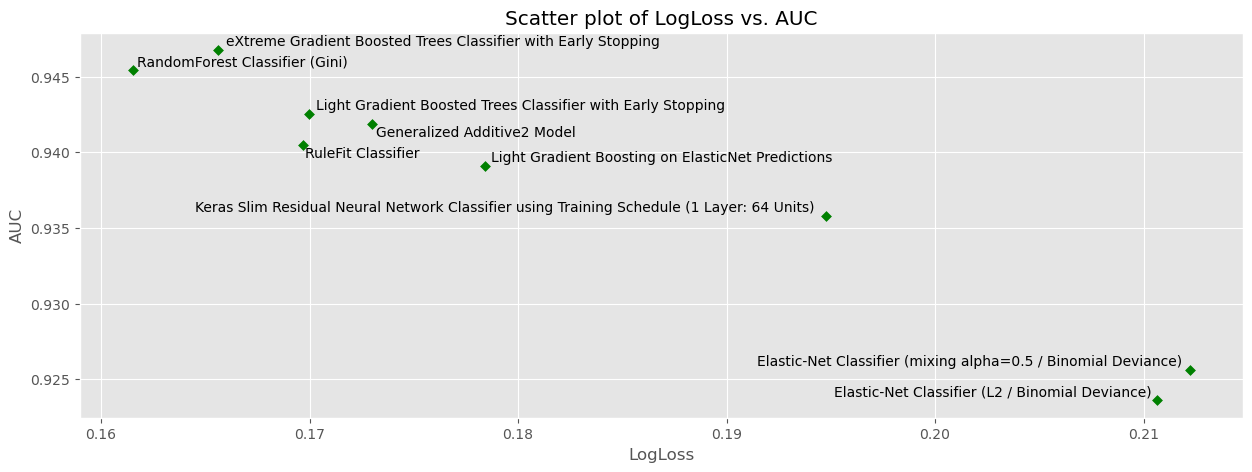

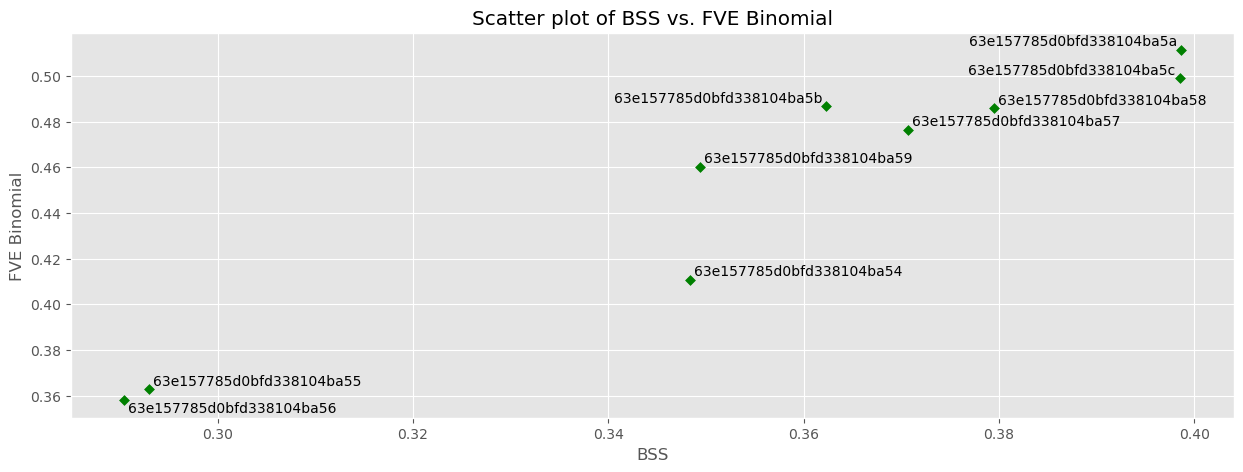

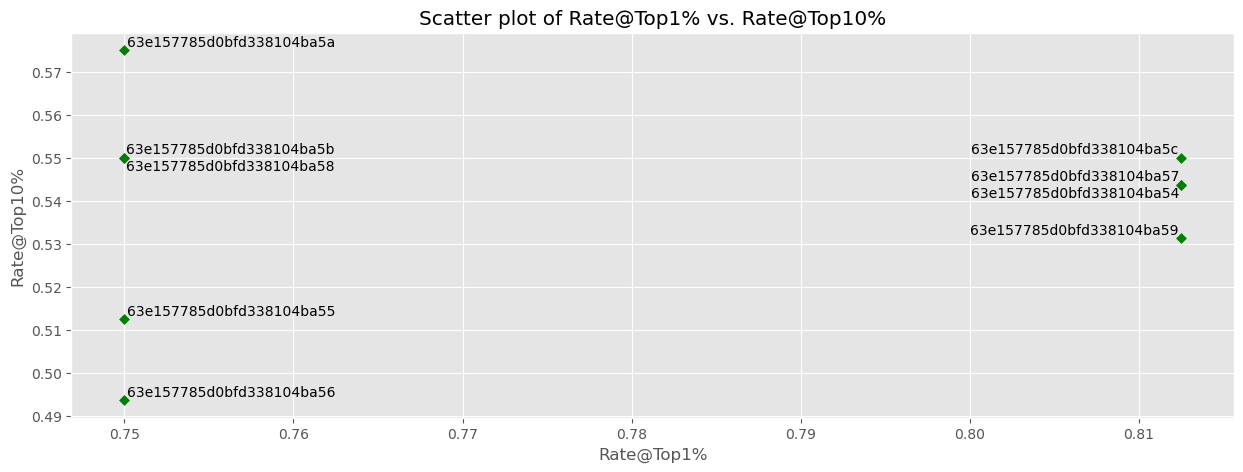

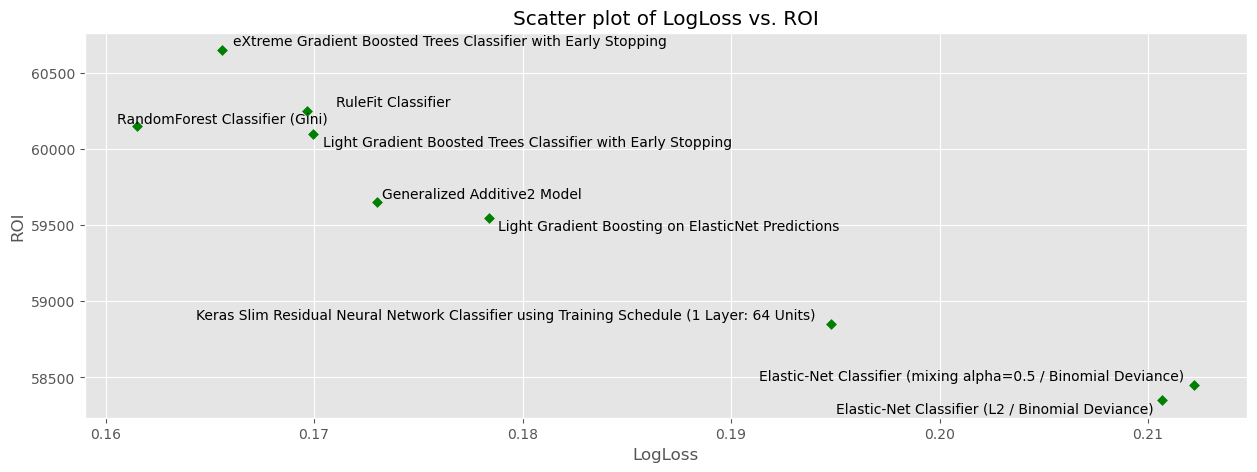

In [30]:
# Make some plots
metrics_to_plot = pd.DataFrame(
    {
        "x_axis_metrics": ["LogLoss", "BSS", "Rate@Top1%", "LogLoss"],
        "y_axis_metrics": ["AUC", "FVE Binomial", "Rate@Top10%", "ROI"],
        "label_as_model_type": [True, False, False, True],
    }
)

# Cycle through each combination
plt.style.use("ggplot")
for i in range(metrics_to_plot.shape[0]):
    # Set metrics
    x_axis_metric = metrics_to_plot["x_axis_metrics"].iloc[i]
    y_axis_metric = metrics_to_plot["y_axis_metrics"].iloc[i]
    label_as_model_type = metrics_to_plot["label_as_model_type"].iloc[i]

    # Make plot
    scatter_plot(
        df=plot_data,
        x_axis_metric=x_axis_metric,
        y_axis_metric=y_axis_metric,
        label_as_model_type=label_as_model_type,
        figsize=(15, 5),
        color="green",
        marker="D",
        s=25,
        title=f"Scatter plot of {x_axis_metric} vs. {y_axis_metric}",
        xlabel=x_axis_metric,
        ylabel=y_axis_metric,
    )